<a href="https://colab.research.google.com/github/AyeshW/TaxiFare/blob/master/Trip_Fare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive, files
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", 100)

In [0]:
df = pd.read_csv(
    "/content/gdrive/My Drive/Colab Notebooks/TaxiFare/train.csv", 
    index_col="tripid"
)
print(df.dtypes)
df.head()

In [0]:
label_df = pd.DataFrame(df['label'])
feature_df = df.drop(columns='label')
feature_df.head()

In [0]:
label_df['label_copy'] = label_df['label']
labels ={"label": {"correct": 1, "incorrect": 0}}
label_df.replace(labels, inplace=True)
label_df.head()

In [7]:
label_df['label'].value_counts()

1    15495
0     1681
Name: label, dtype: int64

In [8]:
label_df.drop(columns='label_copy', inplace=True)
label_df.head()

,label
tripid,
189123628,1
189125358,1
189125719,1
189127273,1
189128020,1


In [0]:
def set_trip_time(df):
    df['pickup_time'] = pd.to_datetime(df['pickup_time'])
    df['drop_time'] = pd.to_datetime(df['drop_time'])
    df['trip_time'] = (df['drop_time'] - df['pickup_time']).dt.total_seconds()
    df.drop(columns=['pickup_time', 'drop_time'], inplace=True)

set_trip_time(feature_df)
feature_df.head()

In [0]:
def get_distance(lat1, lon1, lat2, lon2):
    # haversine_distance
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   lamb1 = np.radians(lon1)
   lamb2 = np.radians(lon2)

   delta_phi = phi2 - phi1
   delta_lambda = lamb2 - lamb1
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
   return np.round(res, 3)

def set_distance(feature_df):
    distances = []
    for row in feature_df.itertuples(index=False):
        distances.append(get_distance(row.pick_lat, row.pick_lon, row.drop_lat, row.drop_lon))
    
    feature_df['trip_distance'] = distances
    feature_df.drop(columns=['pick_lat', 'pick_lon', 'drop_lat', 'drop_lon'], inplace=True)

# Calling the set_distance to set a distance column and remove coordinates columns
set_distance(feature_df)
feature_df.head()

In [0]:
feature_df.describe()

In [0]:
def set_time_error(feature_df):
    time_errors = []
    feature_df['time_error'] = (feature_df['duration'] - feature_df['trip_time'])**2
    #feature_df.drop(columns=['duration', 'trip_time'], inplace=True)

set_time_error(feature_df)
feature_df.head()

In [0]:
def feature_process(feature_df):
    set_trip_time(feature_df)
    set_distance(feature_df)
    set_time_error(feature_df)

In [14]:
(feature_df.shape, label_df.shape)

((17176, 9), (17176, 1))

In [15]:
feature_df.dtypes

additional_fare              float64
duration                     float64
meter_waiting                float64
meter_waiting_fare           float64
meter_waiting_till_pickup    float64
fare                         float64
trip_time                    float64
trip_distance                float64
time_error                   float64
dtype: object

In [16]:
feature_df.isnull().sum()

additional_fare              202
duration                     202
meter_waiting                202
meter_waiting_fare           202
meter_waiting_till_pickup    202
fare                         137
trip_time                      0
trip_distance                  0
time_error                   202
dtype: int64

# Visualizing Data


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


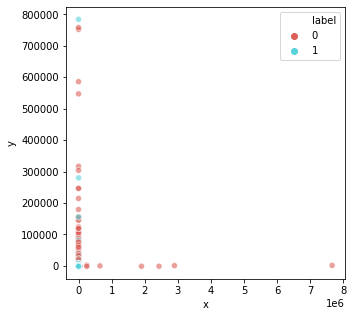

In [17]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

imputer = SimpleImputer()
data = imputer.fit_transform(feature_df)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data)

temp_df = pd.DataFrame({'x': pca_result[:,0], 'y': pca_result[:,1], 'label': label_df['label']})

# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(temp_df.shape[0])

plt.figure(figsize=(5,5))
sns.scatterplot(
    x="x", y="y",
    hue="label",
    palette=sns.color_palette("hls", 2),
    data=temp_df,
    legend="full",
    alpha=0.6
)

# Building Models

In [0]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.metrics import f1_score

RANDOM_SEED = 6    # Set a random seed for reproducibility!

## Setting-up the Pre-Processor

In [0]:
# chain preprocessing into a Pipeline object
# each step is a tuple of (name you chose, sklearn transformer)

# SimpleImputer(strategy='median', add_indicator=False) - RandomForest model
# SimpleImputer(strategy='median', add_indicator=True) - LogisticRegression
preprocessor = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='median', add_indicator=True)),
    ('scaler', MinMaxScaler())
])

## Selecting the best model

In [26]:
#%%script false --no-raise-error
models = [
    RandomForestClassifier(class_weight={1: 0.8, 0: 0.2}, criterion='entropy', max_depth=15, max_features=5, min_impurity_decrease=0, n_estimators=300, random_state=6),
    LogisticRegression(C=100, class_weight={1: 0.2, 0: 0.8}, max_iter=100, penalty='l1', solver='liblinear', random_state=0, n_jobs=-1)
    #MultinomialNB(),
    #BernoulliNB(),
    #LogisticRegression(random_state=0),
    #SGDClassifier(),
    #LinearSVC()
]

processed_models = {}
for model in models:
    name = model.__class__.__name__
    processed_models[name] = Pipeline([("preprocessor", preprocessor),
                                      ("estimator", model)])
    
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for (name, model) in processed_models.items():
  f1_scores = cross_val_score(model, feature_df, label_df.label, scoring='f1_macro', cv=CV)
  for fold_idx, f1 in enumerate(f1_scores):
    entries.append((name, fold_idx, f1))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'f1_score'])

print(cv_df)
print(cv_df.groupby('model_name').f1_score.mean())

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/

               model_name  fold_idx  f1_score
0  RandomForestClassifier         0  0.832875
1  RandomForestClassifier         1  0.785866
2  RandomForestClassifier         2  0.802353
3  RandomForestClassifier         3  0.819904
4  RandomForestClassifier         4  0.796857
5      LogisticRegression         0  0.703534
6      LogisticRegression         1  0.702486
7      LogisticRegression         2  0.713934
8      LogisticRegression         3  0.736526
9      LogisticRegression         4  0.749623
model_name
LogisticRegression        0.721221
RandomForestClassifier    0.807571
Name: f1_score, dtype: float64


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Hyper-Parameter Tuning

In [24]:
%%script false --no-raise-error
# RandomForestClassifier(class_weight={1: 0.8, 0: 0.2}, criterion='entropy', max_depth=15, max_features=5, min_impurity_decrease=0, n_estimators=300, random_state=6, n_jobs=-1)
# LogisticRegression(C=100, class_weight={1: 0.2, 0: 0.8}, max_iter=100, penalty=l1', solver=liblinear')
cross_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", LogisticRegression(C=100, class_weight={1: 0.2, 0: 0.8}, max_iter=100, penalty='l1', solver='liblinear', random_state=0, n_jobs=-1)),
])

# estimator parameter tuning - Random Forest
criterion = ['gini', 'entropy']
n_estimators = [100, 200, 300, 50]
max_depth = [3, 5, 10, 15]
max_features = [5, 'log2', 'auto']
min_impurity_decrease = [0, 0.2, 0.5, 1.0]
class_weight = [{1:0.5, 0:0.5}, {1:0.2, 0:0.8}, {1:0.8, 0:0.2}, {1:0.3, 0:0.7}]

param_grid1 = dict(estimators__criterion =criterion,
                  estimators__n_estimators =n_estimators,
                  estimators__max_depth=max_depth,
                  estimators__max_features =max_features,
                  estimators__min_impurity_decrease=min_impurity_decrease,
                  estimators__class_weight=class_weight)

# estimator parameter tuning - Linear Regression
penalty = ['l1', 'l2'] # , 'elasticnet'
C = [0.001, 0.01, 0.1, 1, 10, 100]
class_weight = [{1:0.5, 0:0.5}, {1:0.2, 0:0.8}, {1:0.8, 0:0.2}, {1:0.3, 0:0.7}]
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
max_iter = [100, 200, 300]

param_grid2 = dict(estimators__penalty = penalty,
                  estimators__C = C,
                  estimators__max_iter = max_iter,
                  estimators__solver = solver,
                  estimators__class_weight=class_weight)

# preprocessor parameter tuning
strategy = ['mean', 'median', 'most_frequent']
indicator = [True, False]
param_grid3 = dict(preprocessor__simple_imputer__strategy = strategy,
                   preprocessor__simple_imputer__add_indicator = indicator)

X_trainc, X_evalc, y_trainc, y_evalc = train_test_split(
    feature_df,
    label_df,
    test_size=0.33,
    shuffle=True,
    stratify=label_df,
    random_state=RANDOM_SEED
)

grid = GridSearchCV(estimator=cross_pipeline,
                    param_grid=param_grid3,
                    scoring='f1_macro',
                    verbose=1,
                    n_jobs=-1)
grid.fit(X_trainc, y_trainc)

print("Model: Random Forest")
print("Best param: ",grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
#print(cross_pipeline.get_params().keys())

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Model: Random Forest
Best param:  {'preprocessor__simple_imputer__add_indicator': True, 'preprocessor__simple_imputer__strategy': 'median'}
Best estimator:  Pipeline(memory=None,
         steps=[('preprocessor',
                 Pipeline(memory=None,
                          steps=[('simple_imputer',
                                  SimpleImputer(add_indicator=True, copy=True,
                                                fill_value=None,
                                                missing_values=nan,
                                                strategy='median', verbose=0)),
                                 ('scaler',
                                  MinMaxScaler(copy=True,
                                               feature_range=(0, 1)))],
                          verbose=False)),
                ('estimators',
                 LogisticRegression(C=100, class_weight={0: 0.8, 1: 0.2},
                                    dual=False, fit_intercept=True,
               

# Train & Evaluation

In [0]:
estimator=RandomForestClassifier(class_weight={1: 0.8, 0: 0.2}, criterion='entropy', max_depth=15, max_features=5, min_impurity_decrease=0, n_estimators=300, random_state=6)

full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimator),
])

In [0]:
X_train, X_eval, y_train, y_eval = train_test_split(
    feature_df,
    label_df,
    test_size=0.33,
    shuffle=True,
    stratify=label_df,
    random_state=RANDOM_SEED
)

In [0]:
%%time

# Train model
full_pipeline.fit(X_train, y_train)

# Predict on evaluation set
preds = full_pipeline.predict(X_eval)
print(preds)

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[1 1 1 ... 1 1 1]
CPU times: user 15.5 s, sys: 16.9 ms, total: 15.5 s
Wall time: 15.5 s


In [0]:
print("Macro F1_Score: {}".format(f1_score(y_eval, preds))) #, average='macro'

Macro F1_Score: 0.9728172125636347


Text(0.5, 15.0, 'Predicted')

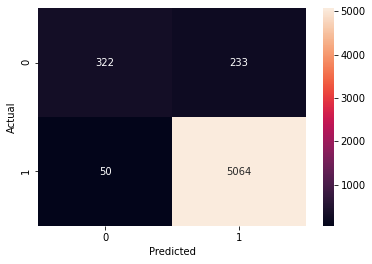

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_eval, preds)
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Predicting on Test Data

In [0]:
%%time 

full_pipeline.fit(feature_df, label_df)
None

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


CPU times: user 22.6 s, sys: 17.6 ms, total: 22.6 s
Wall time: 22.6 s


In [0]:
test_features_df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/TaxiFare/test.csv", 
                               index_col="tripid")

In [0]:
feature_process(test_features_df)
test_predictions = full_pipeline.predict(test_features_df)
test_predictions

array([1, 1, 1, ..., 1, 1, 1])

In [0]:
submission_df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/TaxiFare/sample_submission.csv", 
                            index_col="tripid")

In [0]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_features_df.index.values, 
                              submission_df.index.values)

# Save predictions to submission data frame
submission_df["prediction"] = test_predictions

submission_df.head()

,prediction
tripid,
213284604,1
213286352,1
213293973,1
213294622,1
213298687,1


In [0]:
submission_df.to_csv('/content/gdrive/My Drive/Colab Notebooks/H1N1/data/my_submission.csv', index=True)

In [0]:
!head /content/gdrive/My\ Drive/Colab\ Notebooks/H1N1/data/my_submission.csv

tripid,prediction
213284604,1
213286352,1
213293973,1
213294622,1
213298687,1
213299545,1
213302332,1
213302671,1
213305594,1


In [0]:
dat = pd.DataFrame({'A': [12,34,56,78, 23,None, None], 'B': [90,80,70,23,None, 78, None]})
dat['B1'] = dat['B'].isnull()
dat['A1'] = dat['A'].isnull()
dat['ismissing'] = dat['A1'] == dat['B']
dat

ValueError: ignored